In [44]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.0'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [45]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-06-27 03:02:40--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.1’

postgresql-42.2.16. 100%[===================>] 979.38K  1.21MB/s    in 0.8s    

2021-06-27 03:02:42 (1.21 MB/s) - ‘postgresql-42.2.16.jar.1’ saved [1002883/1002883]



In [46]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [47]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("amazon_reviews_us_Video_Games_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True)

df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   12039526| RTIS3L2M1F5SM|B001CXYMFS|     737716809|Thrustmaster T-Fl...|     Video Games|          5|            0|          0|   N|                Y|an amazing joysti...|Used this for Eli...| 2015-08-31|
|         US|    9636577| R1ZV7R40OLHKD|B00M920ND6|     569686175|Tonsee 6 buttons ...|     Video Games|          5|    

In [48]:
# Create vine_table dataframe
vine_table = df.select('review_id', 'star_rating', 'helpful_votes', 'total_votes', 'vine','verified_purchase')

vine_table.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RTIS3L2M1F5SM|          5|            0|          0|   N|                Y|
| R1ZV7R40OLHKD|          5|            0|          0|   N|                Y|
|R3BH071QLH8QMC|          1|            0|          1|   N|                Y|
|R127K9NTSXA2YH|          3|            0|          0|   N|                Y|
|R32ZWUXDJPW27Q|          4|            0|          0|   N|                Y|
|R3AQQ4YUKJWBA6|          1|            0|          0|   N|                Y|
|R2F0POU5K6F73F|          5|            0|          0|   N|                Y|
|R3VNR804HYSMR6|          5|            0|          0|   N|                Y|
| R3GZTM72WA2QH|          5|            0|          0|   N|                Y|
| RNQOY62705W1K|          4|            0|          0|   N|     

In [49]:
# Get total_votes that is equal to or greater than 20.
votes_geq_20 = vine_table.filter('total_votes>=20')
votes_geq_20.show(10)

#test = votes_geq_20.filter((votes_geq_20['vine'] != 'Y')|(votes_geq_20['vine'] != 'N'))



+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| R4PKAZRQJJX14|          1|           21|         34|   N|                N|
|R2CI0Y288CC7E2|          1|           21|         35|   N|                Y|
|R127WEQY2FM1T3|          1|          147|        175|   N|                Y|
|R3EZ0EPYLDA34S|          1|           14|         31|   N|                Y|
|R2FJ94555FZH32|          2|           55|         60|   N|                N|
|R1U3AR67RE273L|          1|           51|         65|   N|                Y|
|R3PZOXA5X1U8KW|          4|           31|         36|   N|                N|
| R6KTC1OPIOIIG|          2|           19|         34|   N|                Y|
|R36O341WWXXKNP|          5|           28|         31|   N|                N|
|R3GSK9MM8DNOYI|          1|            4|         32|   N|     

In [50]:
# Get number of helpful_votes divided by total_votes that is equal to or greater than 50%.
over_50_df = votes_geq_20.filter('helpful_votes/total_votes*100 >=50')

over_50_df.count()

40565

In [52]:
# Filter out the paid vine reviews.
vine_review_df = over_50_df.filter(over_50_df['vine'] == 'Y')

vine_review_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3KKUSGFZWSUIY|          5|           56|         63|   Y|                N|
|R10FO5UKKVZBK2|          3|           23|         23|   Y|                N|
| RM4KSGEOR7MU1|          5|           19|         24|   Y|                N|
| RG7VRMYLEXD23|          4|           22|         26|   Y|                N|
|R11O4YSCPSNL6L|          3|           20|         26|   Y|                N|
|R286MFBAJ8NPD6|          5|           46|         51|   Y|                N|
|R1JRR530H4COA2|          5|           22|         28|   Y|                N|
| RQ5WD90PUNBU9|          5|           21|         24|   Y|                N|
|R12648VHCQWUV9|          4|           21|         28|   Y|                N|
|R3KAW29CJ8L6DQ|          5|           17|         20|   Y|     

In [53]:
# Filter out the unpaid vine reviews
non_vine_review_df = over_50_df.filter(over_50_df['vine'] == 'N')

non_vine_review_df.show(5)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| R4PKAZRQJJX14|          1|           21|         34|   N|                N|
|R2CI0Y288CC7E2|          1|           21|         35|   N|                Y|
|R127WEQY2FM1T3|          1|          147|        175|   N|                Y|
|R2FJ94555FZH32|          2|           55|         60|   N|                N|
|R1U3AR67RE273L|          1|           51|         65|   N|                Y|
+--------------+-----------+-------------+-----------+----+-----------------+
only showing top 5 rows



In [54]:
# Number of paid vine reviews
vine_paid_count = vine_review_df.count()
print('Number of paid vine reviews: ', vine_paid_count)
    
# Number of unpaid vine reviews
unpaid_count = non_vine_review_df.count()
print('Number of non vine reviews: ', unpaid_count)

# Total number of reviews (vine and non-vine combined)
total_reviews = unpaid_count + vine_paid_count
print('Total number of reviews: ', total_reviews)

Number of paid vine reviews:  94
Number of non vine reviews:  40471
Total number of reviews:  40565


In [68]:
# Vine paid reviews groupby rating
unsorted_groupby_reviews = vine_review_df.groupBy('star_rating').count()

groupby_reviews = unsorted_groupby_reviews.sort('star_rating')

groupby_reviews.show()

+-----------+-----+
|star_rating|count|
+-----------+-----+
|          1|    1|
|          2|    5|
|          3|   16|
|          4|   24|
|          5|   48|
+-----------+-----+



In [66]:
# Unpaid reviews groupby rating
unsorted_groupby_reviews_unpaid = non_vine_review_df.groupBy('star_rating').count()

groupby_reviews_unpaid = unsorted_groupby_reviews_unpaid.sort('star_rating')

groupby_reviews_unpaid.show()

+-----------+-----+
|star_rating|count|
+-----------+-----+
|          1|10303|
|          2| 3388|
|          3| 4379|
|          4| 6738|
|          5|15663|
+-----------+-----+



In [58]:
# Number of 5 star reviews for vine paid reviews
five_star_reviews_paid_df = vine_review_df.filter("star_rating == '5'")

five_star_reviews_paid = five_star_reviews_paid_df.count()

print('Number of 5 star vine reviews: ', five_star_reviews_paid)

Number of 5 star vine reviews:  48


In [60]:
# Number of 5 star reviews for vine unpaid reviews
five_star_unpaid_view_df = non_vine_review_df.filter("star_rating == '5'")

five_star_unpaid_view = five_star_unpaid_view_df.count()

print('Number of 5 star unpaid reviews: ', five_star_unpaid_view)

Number of 5 star unpaid reviews:  15663


In [61]:
# Percentage of 5-star reviews for paid vine reviews
percent_five_star_paid_reviews = five_star_reviews_paid/vine_paid_count*100
print('% of 5 star paid vine reviews: ', percent_five_star_paid_reviews)

# Percentage of 5-star reviews for unpaid reviews
percent_five_star_unpaid_reviews = five_star_unpaid_view/unpaid_count*100
print('% of 5 star unpaid reviews: ', percent_five_star_unpaid_reviews)





% of 5 star paid vine reviews:  51.06382978723404
% of 5 star unpaid reviews:  38.701786464381904


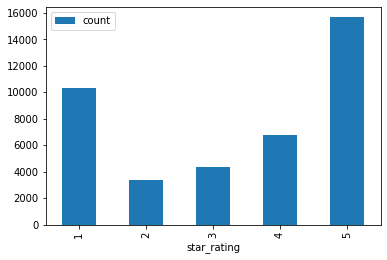

In [69]:
import pandas as pd
unpaid_reviews_bar = groupby_reviews_unpaid.toPandas()

unpaid_reviews_bar.plot.bar("star_rating", "count")

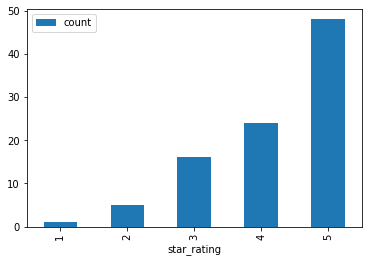

In [70]:
paid_reviews_bar = groupby_reviews.toPandas()

paid_reviews_bar.plot.bar("star_rating", "count")



